In [2]:
# import dependencies 
import numpy as np
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, log_loss, confusion_matrix 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.base import TransformerMixin, BaseEstimator
import matplotlib.pyplot as plt
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from processing_scripts import data_pipelines as dp
pd.set_option('display.max_rows', 200)
%matplotlib inline

# define folder where data resides 
DATAFOLDER = "/Users/snuffles753/Documents/NYU-GSAS/ds1003/term-project/data"

In [ ]:
import csv
import os
def create_dchen_subset():
    with open(os.path.join(DATAFOLDER,'final_subset.csv'), 'w') as f_write:
        with open(os.path.join(DATAFOLDER,'decision_sched_merge_adjdate.csv'), "r") as f:
            read = csv.DictReader(f, delimiter=',')
            first = True
            for row in read:
                if first:
                    f_write.write("case_id,proceeding_id,year,judge_id,nationality,lawyer,city_id,decision\n")
                    first = False
                else:
                    f_write.write("{},{},{},{},{},{},{},{}\n".format(row['idncase'], row['idnproceeding'],
                                                                  row['input_year'], row['judgeid'],
                                                                  row['nat'],row['lawyer'],row['cityid'],
                                                                  row['dec_string']))

In [3]:
# main table 
tblAppeal = pd.read_csv(os.path.join(DATAFOLDER, 'raw/tblAppeal.csv'), low_memory=False) 

# drop appeals with no case number, proceeding number, or decision 
tblAppeal.dropna(subset=['idncase', 'idnProceeding', 'strBIADecision'], inplace=True) 
tblAppeal = tblAppeal[tblAppeal['idnProceeding'] != 0] # drop zeros 

tblAppeal = tblAppeal[['idncase', 'idnProceeding', 'strBIADecision']]

# convert indexes to integers 
tblAppeal['idncase'] = tblAppeal['idncase'].astype(int) 
tblAppeal['idnProceeding'] = tblAppeal['idnProceeding'].astype(int) 
tblAppeal.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755222 entries, 0 to 869457
Data columns (total 3 columns):
idncase           755222 non-null int64
idnProceeding     755222 non-null int64
strBIADecision    755222 non-null object
dtypes: int64(2), object(1)
memory usage: 23.0+ MB


In [4]:
dchen_df = pd.read_csv(os.path.join(DATAFOLDER, 'final_subset.csv'), low_memory=False) 

# drop records with no case number, proceeding number, or decision 
dchen_df.dropna(subset=['case_id', 'proceeding_id', 'decision'], inplace=True) 
dchen_df = dchen_df[dchen_df['proceeding_id'] != 0] # drop zeros 

# convert indexes to integers 
dchen_df['case_id'] = dchen_df['case_id'].astype(int) 
dchen_df['proceeding_id'] = dchen_df['proceeding_id'].astype(int) 


In [5]:
dchen_with_appeals = dchen_df.merge(tblAppeal, how='left', 
                                    left_on=['case_id', 'proceeding_id'], 
                                    right_on=['idncase', 'idnProceeding'])
dchen_with_appeals.head(5)

,case_id,proceeding_id,year,judge_id,nationality,lawyer,city_id,decision,idncase,idnProceeding,strBIADecision
0,2046921,3200049,2004.0,325,MX,0,9,REMOVE,NaN,NaN,NaN
1,2046922,3200050,2004.0,194,MX,0,9,REMOVE,NaN,NaN,NaN
2,2046923,3200051,2004.0,56,PL,1,9,REMOVE,2046923.0,3200051.0,REM
3,2046923,3200051,2004.0,56,PL,1,9,REMOVE,2046923.0,3200051.0,DIS
4,2046923,3525150,2005.0,133,PL,1,9,TRANSFER,NaN,NaN,NaN


In [6]:
dchen_with_appeals['has_appealed'] = np.where(dchen_with_appeals['idncase'].isnull(), 0 ,1)
dchen_with_appeals.head(5)

,case_id,proceeding_id,year,judge_id,nationality,lawyer,city_id,decision,idncase,idnProceeding,strBIADecision,has_appealed
0,2046921,3200049,2004.0,325,MX,0,9,REMOVE,NaN,NaN,NaN,0
1,2046922,3200050,2004.0,194,MX,0,9,REMOVE,NaN,NaN,NaN,0
2,2046923,3200051,2004.0,56,PL,1,9,REMOVE,2046923.0,3200051.0,REM,1
3,2046923,3200051,2004.0,56,PL,1,9,REMOVE,2046923.0,3200051.0,DIS,1
4,2046923,3525150,2005.0,133,PL,1,9,TRANSFER,NaN,NaN,NaN,0


In [7]:
dchen_with_appeals.describe()

,case_id,proceeding_id,year,judge_id,lawyer,city_id,idncase,idnProceeding,has_appealed
count,5.846836e+06,5.846836e+06,5.819137e+06,5.846836e+06,5.846836e+06,5.846836e+06,7.420390e+05,7.420390e+05,5.846836e+06
mean,4.438167e+06,2.906617e+06,2.001464e+03,2.170733e+02,4.997739e-01,2.895782e+01,3.921895e+06,2.342052e+06,1.269129e-01
std,1.478179e+06,1.707648e+06,6.977928e+00,1.245805e+02,5.000000e-01,1.442345e+01,1.229076e+06,1.452175e+06,3.328754e-01
min,2.046921e+06,1.000000e+00,1.900000e+03,1.000000e+00,0.000000e+00,1.000000e+00,2.046923e+06,3.400000e+01,0.000000e+00
25%,3.162106e+06,1.447033e+06,1.996000e+03,1.120000e+02,0.000000e+00,1.800000e+01,2.937252e+06,1.145865e+06,0.000000e+00
50%,4.238320e+06,2.845606e+06,2.002000e+03,2.120000e+02,0.000000e+00,2.800000e+01,3.774473e+06,2.207262e+06,0.000000e+00
75%,5.757074e+06,4.343629e+06,2.007000e+03,3.250000e+02,1.000000e+00,4.000000e+01,4.530242e+06,3.245905e+06,0.000000e+00
max,7.218431e+06,6.186101e+06,2.013000e+03,4.350000e+02,1.000000e+00,5.600000e+01,7.215995e+06,6.182150e+06,1.000000e+00


In [ ]:
cat_feature_values = dict([(f, df[f].dropna().unique().tolist()) for f in cat_features]) # do EDA and limit to smaller list 

dummify = dp.get_model_data(cat_feature_values)
dchen_with_appeals_dum = dummify.transform(dchen_with_appeals)
dchen_with_appeals_dum.head()

Training Data: (4677468, 265) | Test Data: (1169368, 265)


{'Accuracy': 0.87299806391144619,
 'Log Loss': 0.35425033550190788,
 'ROC AUC': 0.68443368354521084}

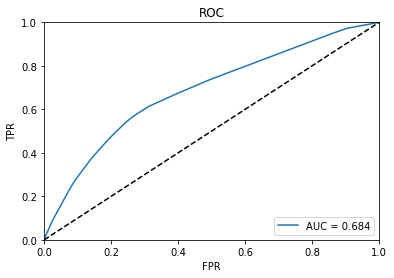

In [8]:
# nationality only 
CAT_FEATURES = ['nationality']
NUM_FEATURES = []
IMPUTE_METHODS = {'nationality': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = dp.get_model_data(dchen_with_appeals, 
                                                  label='has_appealed', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
dp.train_model(MODEL, X_train, y_train, X_test, y_test, plot_auc=True)

Training Data: (4677468, 763) | Test Data: (1169368, 763)


{'Accuracy': 0.87299806391144619,
 'Log Loss': 0.32461330183637005,
 'ROC AUC': 0.77056192173118887}

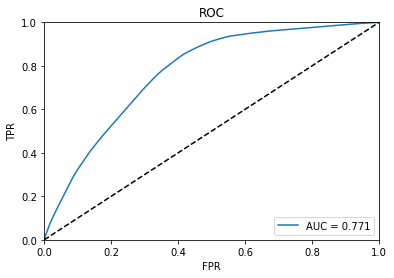

In [10]:
CAT_FEATURES = ['nationality', 'judge_id', 'year']
NUM_FEATURES = ['lawyer']
IMPUTE_METHODS = {'nationality': 'none', 'judge_id': 'none', 'year': 'none', 'lawyer': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = dp.get_model_data(dchen_with_appeals, 
                                                  label='has_appealed', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
dp.train_model(MODEL, X_train, y_train, X_test, y_test, plot_auc=True)